<a href="https://colab.research.google.com/github/ydsyvn/Spray-Wall-Boulder-Genration/blob/main/final_project_hold_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<h1 dir="rtl">פרוייקט סיום - סגמנטצית אחיזות טיפוס - עידו סיון</h1>



לקחתי את הנתונים מפה:
[github](https://github.com/mcloses/smear-beta)

כתבה שימושית: [Modify Dataset class for COCO data](https://medium.com/fullstackai/how-to-train-an-object-detector-with-your-own-coco-dataset-in-pytorch-319e7090da5)

In [1]:
import numpy as np
import os
import json
from PIL import Image
import matplotlib.pyplot as plt
import random

In [2]:
# Mount drive and get dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## <h2 > visualizing the dataset </h2>

<ipython-input-3-82dfb903ca83>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10')


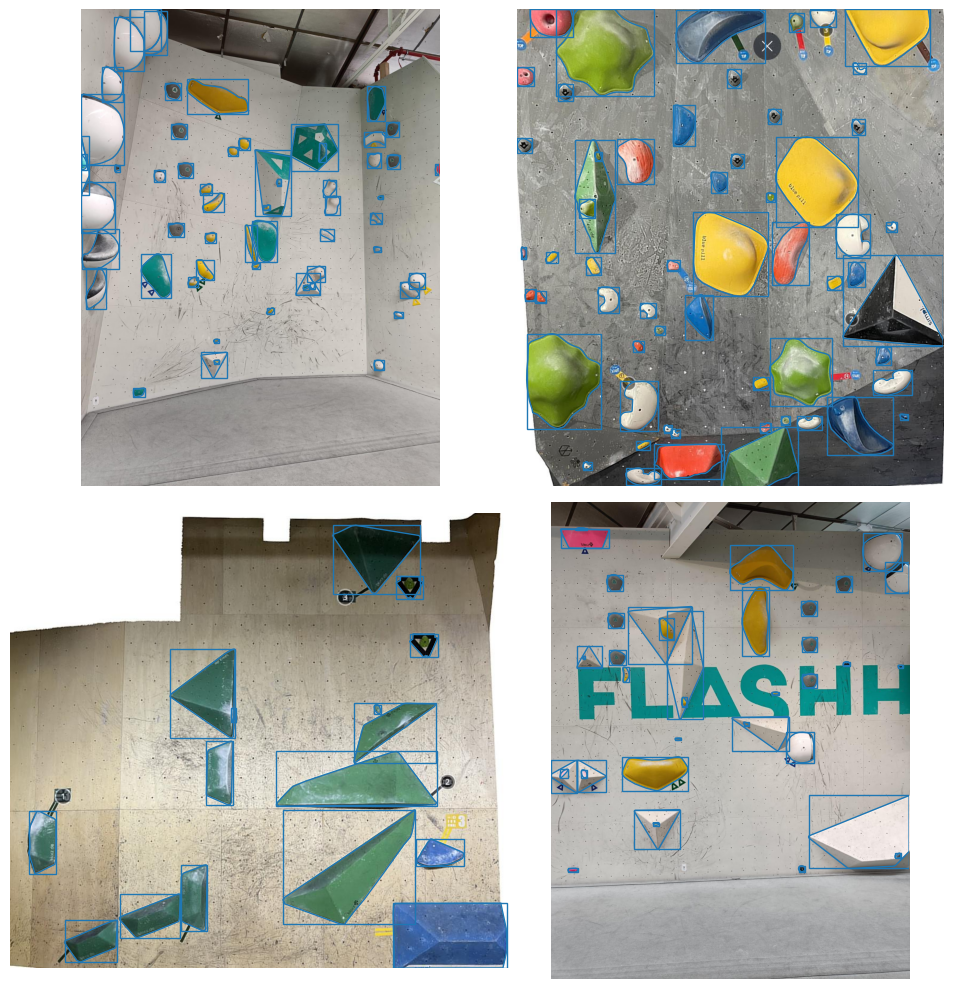

In [3]:
import matplotlib.patches as patches
import cv2

def display_images_with_coco_annotations(image_paths, annotations, display_type='both', colors=None):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    for ax, img_path in zip(axs.ravel(), image_paths):
        # Load image using OpenCV and convert it from BGR to RGB color space
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ax.imshow(image)
        ax.axis('off')  # Turn off the axes

        # Define a default color map if none is provided
        if colors is None:
            colors = plt.cm.get_cmap('tab10')

        # Get image filename to match with annotations
        img_filename = os.path.basename(img_path)
        img_id = next(item for item in annotations['images'] if item["file_name"] == img_filename)['id']

        # Filter annotations for the current image
        img_annotations = [ann for ann in annotations['annotations'] if ann['image_id'] == img_id]

        for ann in img_annotations:
            #category_id = ann['category_id']
            #color = colors(category_id % 10)
            color=colors(0)

            # Display bounding box
            if display_type in ['bbox', 'both']:
                bbox = ann['bbox']
                rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor=color, facecolor='none')
                ax.add_patch(rect)

            # Display segmentation polygon
            if display_type in ['seg', 'both']:
                for seg in ann['segmentation']:
                    poly = [(seg[i], seg[i+1]) for i in range(0, len(seg), 2)]
                    polygon = patches.Polygon(poly, closed=True, edgecolor=color, fill=False)
                    ax.add_patch(polygon)

    plt.tight_layout()
    plt.show()

# Load COCO annotations
with open('/content/drive/MyDrive/Data/hold segmentation/train.json', 'r') as f:
    annotations = json.load(f)

# Get all image files
image_dir = "/content/drive/MyDrive/Data/hold segmentation/segmentation images/"
all_image_files = [os.path.join(image_dir, img['file_name']) for img in annotations['images']]
random_image_files = random.sample(all_image_files, 4)

# Choose between 'bbox', 'seg', or 'both'
display_type = 'both'
display_images_with_coco_annotations(random_image_files, annotations, display_type)



#display_images_with_coco_annotations(['livecell_test_images/SKOV3_Phase_F4_2_03d00h00m_4.tif'], annotations, display_type)

## <h2 > pytorch </h2>

In [3]:
from pycocotools.coco import COCO

import torch
import torch.nn as nn
from torchvision.transforms import functional as F

from torch.utils.data import DataLoader

from sklearn.metrics import jaccard_score
from torchvision.transforms import functional as F
from sklearn.metrics import accuracy_score

from torchvision.models.segmentation import fcn_resnet50
import torchvision.models as models

import torch.optim as optim

###<h3> resize the images</h3>

In [4]:
class CocoDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, annotation_file, new_size=(640, 480)):
        self.image_dir = image_dir
        self.new_size = new_size
        self.coco = COCO(annotation_file)
        self.ids = list(self.coco.imgs.keys())

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)

        # Load the image
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.image_dir, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")

        # Load the masks
        masks = np.zeros([img_info['height'], img_info['width']])
        for ann in anns:
            mask = coco.annToMask(ann) * 255
            masks = np.maximum(masks, mask)
        masks = Image.fromarray(masks)

        # Resize image and masks
        img = F.resize(img, self.new_size)
        masks = F.resize(masks, self.new_size)

        # Convert to PyTorch tensors
        img = F.to_tensor(img)
        masks = torch.from_numpy(np.array(masks)).long()

        masks = (masks > 0).long()

        return img, masks

    def __len__(self):
        return len(self.ids)


In [5]:
train_dataset = CocoDataset('/content/drive/MyDrive/Data/hold segmentation/segmentation images', '/content/drive/MyDrive/Data/hold segmentation/train.json')


loading annotations into memory...
Done (t=1.87s)
creating index...
index created!


In [6]:
val_dataset = CocoDataset('/content/drive/MyDrive/Data/hold segmentation/segmentation images', '/content/drive/MyDrive/Data/hold segmentation/test.json')


loading annotations into memory...
Done (t=0.84s)
creating index...
index created!


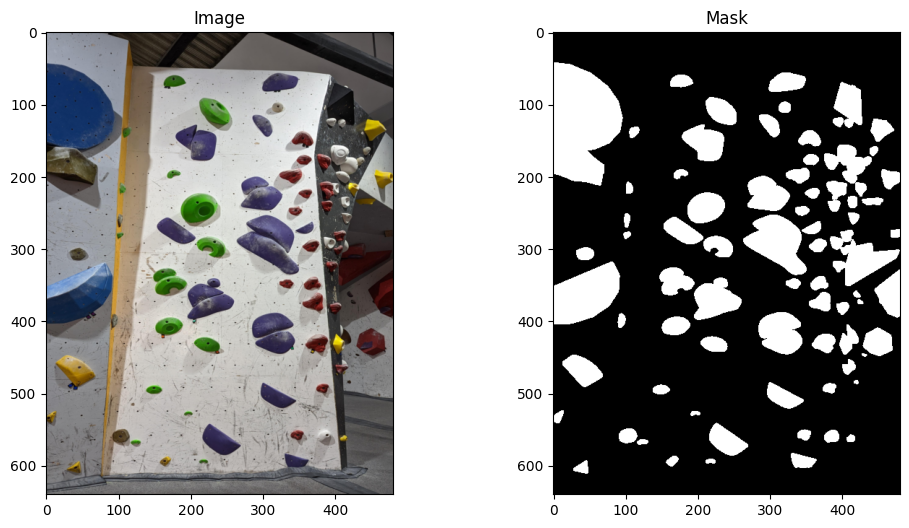

In [7]:


# Select a random image
index = random.randint(0, len(train_dataset) - 1)
img, mask = train_dataset[index]

# Convert tensors to numpy arrays for visualization
img = img.permute(1, 2, 0).numpy()
mask = mask.squeeze().numpy()

# Plot the image and the mask
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(img)
ax[0].set_title('Image')

ax[1].imshow(mask, cmap='gray')
ax[1].set_title('Mask')

plt.show()

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### <h3> transfer learning </h3>


In [55]:
from sklearn.metrics import accuracy_score

def evaluate(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    total_accuracy = 0

    with torch.no_grad():  # Disable gradient calculation
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)['out']
            loss = criterion(outputs, masks.unsqueeze(1).float())
            total_loss += loss.item()

            # Calculate accuracy
            preds = torch.sigmoid(outputs)  # Apply sigmoid to get pixel probabilities
            preds = (preds > 0.5).float()  # Binarize predictions
            accuracy = accuracy_score(masks.cpu().numpy().flatten(), preds.cpu().numpy().flatten())
            total_accuracy += accuracy

    avg_loss = total_loss / len(dataloader)
    avg_accuracy = total_accuracy / len(dataloader)

    return avg_loss, avg_accuracy


In [48]:
# Load the pre-trained weights
pretrained_weights = fcn_resnet50(pretrained=True).state_dict()

# Create a new model
model = fcn_resnet50(pretrained=False, num_classes=1)  # Change num_classes to 1

# Load the weights into the new model, excluding the final layer
model_dict = model.state_dict()
pretrained_dict = {k: v for k, v in pretrained_weights.items() if k in model_dict and "classifier" not in k}
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)


<All keys matched successfully>

In [58]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the final layer
for param in model.classifier.parameters():
    param.requires_grad = True


In [50]:
model = model.to(device)


In [42]:
# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Use Binary Cross Entropy loss for binary segmentation
criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss which combines a Sigmoid layer and the BCELoss in one single class


In [61]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True)


In [62]:
acc_history = []
loss_history = []

# Training loop
for epoch in range(10):  # Adjust the number of epochs
    model.train()
    for images, masks in train_loader:
        # Move data to the correct device
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)['out']
        loss = criterion(outputs, masks.unsqueeze(1).float())  # Convert masks to float

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate on the validation set
    val_loss, val_accuracy = evaluate(model, val_loader, device)
    acc_history.append(val_accuracy)
    loss_history.append(val_loss)

    print(f"Epoch {epoch+1}, Training Loss: {loss.item()}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")


OutOfMemoryError: CUDA out of memory. Tried to allocate 150.00 MiB. GPU 0 has a total capacty of 39.56 GiB of which 84.81 MiB is free. Process 51223 has 39.47 GiB memory in use. Of the allocated memory 38.79 GiB is allocated by PyTorch, and 178.82 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def predict_and_display(model, image_path, device):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image = F.resize(image, (640, 480))  # Adjust the size if necessary
    image = F.to_tensor(image).unsqueeze(0).to(device)

    # Make a prediction
    model.eval()
    with torch.no_grad():
        output = model(image)['out']
    prediction = output.argmax(1).squeeze().cpu().numpy()

    # Load the original image
    original_image = Image.open(image_path)

    # Create a mask image from the prediction
    mask = Image.fromarray(prediction.astype(np.uint8) * 255)

    # Overlay the mask on the original image
    overlay = Image.blend(original_image.convert("RGBA"), mask.convert("RGBA"), alpha=0.5)

    # Display the overlay
    plt.imshow(overlay)
    plt.show()


In [ ]:
path_to_image = '/content/drive/MyDrive/Data/hold segmentation/spraywall images/Img_2023_12_10_12_00_59.jpeg'
predict_and_display(model, path_to_image, device)

ValueError: images do not match

In [ ]:
def predict_random_image(model, folder_path, device):
    # Select a random image from the folder
    image_path = random.choice(os.listdir(folder_path))
    image_path = os.path.join(folder_path, image_path)

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image = F.resize(image, (640, 480))  # Adjust the size if necessary
    image = F.to_tensor(image).unsqueeze(0).to(device)

    # Make a prediction
    model.eval()
    with torch.no_grad():
        output = model(image)['out']
    prediction = output.argmax(1).squeeze().cpu().numpy()

    # Load the original image
    original_image = Image.open(image_path)

    # Create a mask image from the prediction
    mask = Image.fromarray(prediction.astype(np.uint8) * 255)

    # Display the original image and the mask side by side
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(original_image)
    ax[0].set_title('Original Image')
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title('Predicted Mask')
    plt.show()


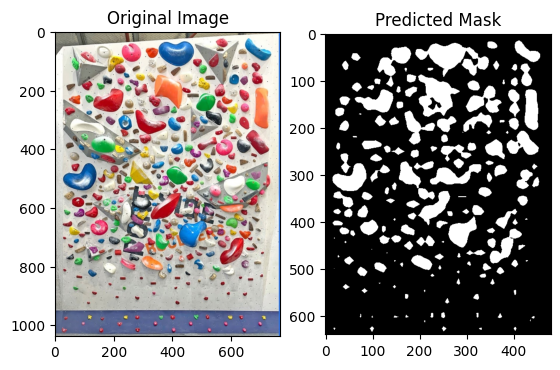

In [ ]:
path_to_folder = '/content/drive/MyDrive/Data/hold segmentation/spraywall images/'
predict_random_image(model, path_to_folder, device)

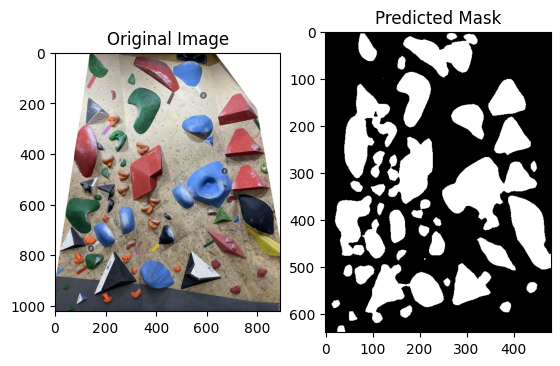

In [ ]:
path_to_folder = '/content/drive/MyDrive/Data/hold segmentation/segmentation images'
predict_random_image(model, path_to_folder, device)

### <h3> CNN model</h3>

In [9]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )

class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()

        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, n_class, 1)


    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out


In [10]:
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu

In [11]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image.
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # output: 570x570x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 28x28x1024


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))

        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

In [12]:
num_classes = 2

In [20]:
UNet_model = UNet(num_classes).to(device)

In [14]:
# Create a DataLoader for your dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [15]:
# Use Binary Cross Entropy loss for binary segmentation
criterion = nn.BCELoss()

# Use Adam optimizer
optimizer = torch.optim.Adam((UNet_model).parameters(), lr=0.001)

In [16]:
epochs = 5

In [21]:

loss_history = []

for epoch in range(epochs):
    for i, data in enumerate(train_loader, 0):
        # Get the inputs
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = UNet_model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

    torch.cuda.empty_cache()
    loss = loss.item()

    loss_history.append(loss)
    print(f"Epoch {epoch+1}/{epochs} Loss: {loss}")


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.34 GiB. GPU 0 has a total capacty of 39.56 GiB of which 2.07 GiB is free. Process 51223 has 37.48 GiB memory in use. Of the allocated memory 32.54 GiB is allocated by PyTorch, and 4.46 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## <h1> keras </h1>

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import Sequence
from pycocotools.coco import COCO
from PIL import Image
import numpy as np
import cv2

In [ ]:

# Path to the annotation file
train_ann_file = '/content/drive/MyDrive/Data/hold segmentation/train.json'
val_ann_file = '/content/drive/MyDrive/Data/hold segmentation/test.json'

# Create a COCO object
train_ds = COCO(train_ann_file)
val_ds = COCO(val_ann_file)

images = '/content/drive/MyDrive/Data/hold segmentation/segmentation images'

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
loading annotations into memory...
Done (t=0.84s)
creating index...
index created!


In [ ]:
images = '/content/drive/MyDrive/Data/hold segmentation/segmentation images'

In [ ]:


class CocoDataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, dataset, target_size=(128, 128), batch_size=32, shuffle=True):
        'Initialization'
        self.dataset = dataset
        self.target_size = target_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.dataset.imgs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.dataset.imgs.keys()[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.dataset.imgs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.target_size, 3))
        y = np.empty((self.batch_size, *self.target_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = cv2.resize(cv2.imread(self.dataset.loadImgs(ID)[0]['file_name']), self.target_size)

            # Store class
            annIds = self.dataset.getAnnIds(imgIds=ID)
            anns = self.dataset.loadAnns(annIds)
            mask = np.zeros((*self.target_size))
            for ann in anns:
                mask = np.maximum(mask, cv2.resize(self.dataset.annToMask(ann), self.target_size))
            y[i] = mask

        return X, y


In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

def conv2d_block(input_tensor, n_filters):
    x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same')(input_tensor)
    x = Activation('relu')(x)
    x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same')(x)
    x = Activation('relu')(x)
    return x

def create_model(input_shape, n_filters=64, n_classes=2):
    inputs = Input(input_shape)

    # Contracting path
    conv1 = conv2d_block(inputs, n_filters=n_filters*1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = conv2d_block(pool1, n_filters=n_filters*2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = conv2d_block(pool2, n_filters=n_filters*4)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = conv2d_block(pool3, n_filters=n_filters*8)

    # Expanding path
    up5 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv3], axis=-1)
    conv5 = conv2d_block(up5, n_filters=n_filters*4)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv2], axis=-1)
    conv6 = conv2d_block(up6, n_filters=n_filters*2)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv1], axis=-1)
    conv7 = conv2d_block(up7, n_filters=n_filters*1)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(conv7)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model


In [ ]:
from keras.optimizers import Adam
from keras.losses import binary_crossentropy





In [ ]:
# Create the model
model = create_model((128, 128, 1))


In [ ]:
# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy')


In [ ]:
# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=10)
